## Airbnb Data Wrangling


## 1.0 Introduction
This step focuses on importing and cleaning the data. 

Recap of the primary goal is to answering the following questions:
1. Which area of Los angeles has the most listing?
2. What features have an impact on the price of a place?
3. Predict the price of a listing in Los Angeles?

##  2.0 Import Packages


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
import datetime as dt
import numpy as np



## 3.0 Load the data
Data downloaded from [Inside Airbnb](http://insideairbnb.com/get-the-data/) and saved to a local file as listings.csv.gz


In [2]:
# only load the listing in "City of Los Angeles"

listings = pd.read_csv('listings.csv.gz', compression='gzip',error_bad_lines=False)
listings=listings[listings.neighbourhood_group_cleansed=="City of Los Angeles"]


C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print(listings.shape)
print(listings.info())

#Check for duplicate listing id

dup= listings.duplicated(subset="id")
print("Dupplicated ID listing",listings[dup==True].count().max())




(21003, 75)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21003 entries, 1 to 40435
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            21003 non-null  int64  
 1   listing_url                                   21003 non-null  object 
 2   scrape_id                                     21003 non-null  int64  
 3   last_scraped                                  21003 non-null  object 
 4   source                                        21003 non-null  object 
 5   name                                          21003 non-null  object 
 6   description                                   20669 non-null  object 
 7   neighborhood_overview                         12693 non-null  object 
 8   picture_url                                   21003 non-null  object 
 9   host_id                                       210

There are 21,003 listings in the area of Los Angeles and each listing has 75 columns. No duplicated ID listing was found. For the purpose of the problem solving, half of the columns seem like they are useful so they will be dropped in the next section. 


##  4.0 Explore the data


### 4.1 Number of missing data by features


In [4]:
#count number of missing data in all columns and sort them from high to low

missing=pd.concat([listings.isnull().sum(),100*listings.isnull().mean()],axis=1)
missing.columns=["count","%"]
print(missing.sort_values(by="count",ascending=False)[missing["count"]>0])

                             count           %
bathrooms                    21003  100.000000
calendar_updated             21003  100.000000
license                      12300   58.563062
neighborhood_overview         8310   39.565776
neighbourhood                 8309   39.561015
host_about                    8022   38.194544
review_scores_value           6872   32.719135
review_scores_location        6871   32.714374
review_scores_checkin         6870   32.709613
review_scores_accuracy        6866   32.690568
review_scores_communication   6865   32.685807
review_scores_cleanliness     6865   32.685807
reviews_per_month             6723   32.009713
first_review                  6723   32.009713
last_review                   6723   32.009713
review_scores_rating          6723   32.009713
host_response_time            5585   26.591439
host_response_rate            5585   26.591439
host_acceptance_rate          5062   24.101319
host_location                 3313   15.773937
bedrooms     

C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


#### Drop data:
1. Drop "bathrooms" and "calendar_updated" columns as they have no data
2. Missing data shows in other columns as well but will keep them all for now as they might hold valueable information for future data exploration 
2. Drop columns that are not useful for data analysis (see drop_list below) 



In [5]:
drop_list=['bathrooms','calendar_updated','name','id','host_id','listing_url','scrape_id','last_scraped','source','description','neighborhood_overview','picture_url','host_url',
      'host_name', 'host_since','host_location','host_about','property_type','host_neighbourhood','neighbourhood_group_cleansed','neighbourhood','host_verifications','host_thumbnail_url',   'host_picture_url', 'calendar_last_scraped',
          'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','host_has_profile_pic','first_review','last_review','host_listings_count','host_total_listings_count',
          'calculated_host_listings_count','calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'  ]
listings=listings.drop(columns=drop_list,axis=1)
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21003 entries, 1 to 40435
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           15418 non-null  object 
 1   host_response_rate           15418 non-null  object 
 2   host_acceptance_rate         15941 non-null  object 
 3   host_is_superhost            20951 non-null  object 
 4   host_identity_verified       21001 non-null  object 
 5   neighbourhood_cleansed       21003 non-null  object 
 6   latitude                     21003 non-null  float64
 7   longitude                    21003 non-null  float64
 8   room_type                    21003 non-null  object 
 9   accommodates                 21003 non-null  int64  
 10  bathrooms_text               20981 non-null  object 
 11  bedrooms                     18760 non-null  float64
 12  beds                         20550 non-null  float64
 13  amenities       

#### The new data set has 34 columns.


### 4.2 Categorical Features
 
List all feaures with "Object" datatype

In [6]:
listings.select_dtypes("object").head(1).T

,1
host_response_time,within a few hours
host_response_rate,75%
host_acceptance_rate,38%
host_is_superhost,t
host_identity_verified,t
neighbourhood_cleansed,Hollywood Hills West
room_type,Private room
bathrooms_text,1 shared bath
amenities,"[""TV with standard cable"", ""Hot water"", ""First..."
price,$46.00


#### host_response_rate,  host_acceptance_rate and price

Will remove special characters and convert them all to numeric


In [7]:
# using str replace function to remove special character and convert them to float

listings.price=listings.price.str.replace("$","").str.replace(",","").astype("float")
listings.host_response_rate=listings.host_response_rate.str.replace("%","").astype("float")/100
listings.host_acceptance_rate=listings.host_acceptance_rate.str.replace("%","").astype("float")/100


C:\Users\vanvb\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


#### bathroom_text
Split bathroom_text into number of bathrooms and the type of bathroom. Need number of bathrooms to find the correlation with price later on

In [8]:
# To get the bathroom quanitty
listings['bathroom_qty']=listings.bathrooms_text.str.split(" ",expand=True)[0]

# To get the bathromm type
listings['bathroom_type']=listings.bathrooms_text.str.split(" ",expand=True)[1]

In [9]:
listings.bathroom_qty.value_counts()

1            12641
2             3333
2.5           1747
1.5            855
3              806
3.5            377
4              272
4.5            230
8              133
5.5            130
5              120
6               82
6.5             47
7               42
0               38
11              27
Shared          20
8.5             14
7.5             14
Half-bath       12
9                9
10               8
9.5              6
Private          3
12               3
11.5             2
13               2
10.5             2
12.5             1
13.5             1
25               1
21               1
20               1
15               1
Name: bathroom_qty, dtype: int64

In [10]:
# what listings have bathroom as "Private"
listings[listings.bathroom_qty=="Private"][["price","room_type","accommodates","bathrooms_text","beds","neighbourhood_cleansed","room_type"]]

,price,room_type,accommodates,bathrooms_text,beds,neighbourhood_cleansed,room_type
10877,60.0,Private room,2,Private half-bath,1.0,Palms,Private room
34281,60.0,Private room,4,Private half-bath,2.0,Hyde Park,Private room
38260,179.0,Private room,2,Private half-bath,1.0,Beverly Crest,Private room


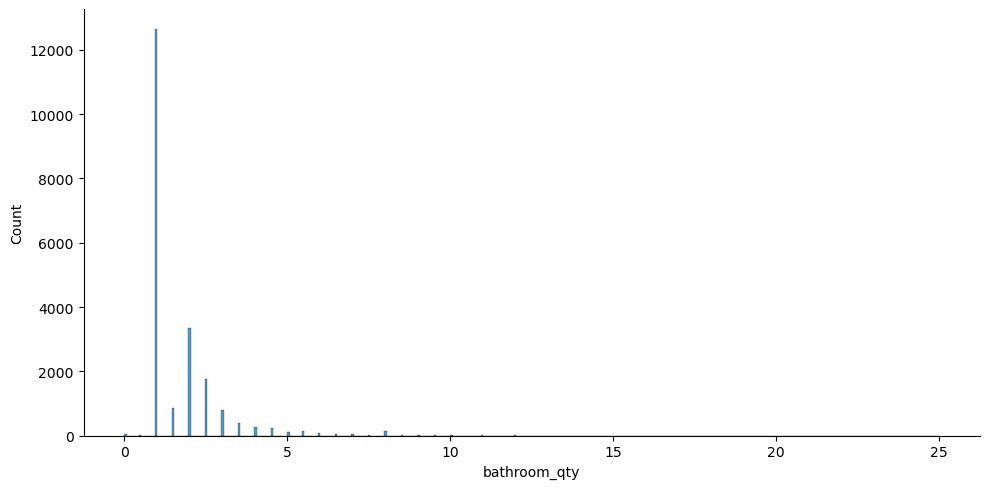

In [11]:
# replace string with number
# "Shared" is replace with 0 bath
# "Half-bath" is relaced with 0.5 bath
# there are 3 listings shows as "Private" baths which are replaced with 0.5 as bathroom_type is Priviate half-bath

listings.loc[listings.bathroom_qty=="Shared",'bathroom_qty']=0
listings.loc[listings.bathroom_qty=="Half-bath",'bathroom_qty']=0.5
listings.loc[listings.bathroom_qty=="Private",'bathroom_qty']=0.5
listings.bathroom_qty=listings.bathroom_qty.astype("float")

# histogram plot for bathroom_qty
sns.displot(data=listings,x="bathroom_qty",kind="hist",aspect=2)




The plot above is the distribution of bathromm_qty after converting to numeric. The majority of listings has 1 bathroom.


### Room type count


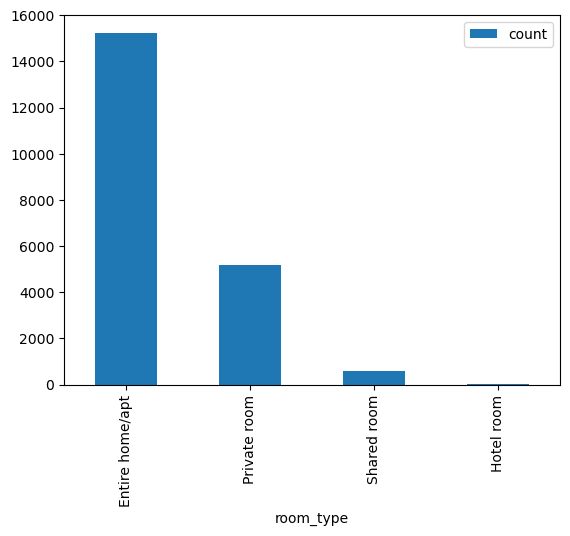

In [12]:
room_count=listings['room_type'].value_counts().to_frame(name="count").reset_index()
room_count.rename(columns = {'index':'room_type'},inplace=True)

room_count.plot.bar(x='room_type',y='count')
plt.show()

There are four room types and "Entire home/apt" type has the most listings

### 4.3 Numeric Features

In [13]:
listings.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
host_response_rate,15418.0,0.952549,0.158097,0.00000,0.99000,1.00000,1.000000,1.00000
host_acceptance_rate,15941.0,0.865848,0.236391,0.00000,0.85000,0.98000,1.000000,1.00000
latitude,21003.0,34.081064,0.074501,33.70549,34.04202,34.08047,34.122420,34.32590
longitude,21003.0,-118.375972,0.093773,-118.66307,-118.45154,-118.36742,-118.305905,-118.15579
accommodates,21003.0,3.823597,2.718514,0.00000,2.00000,3.00000,5.000000,16.00000
bedrooms,18760.0,1.777665,1.227769,1.00000,1.00000,1.00000,2.000000,24.00000
beds,20550.0,2.113090,1.575692,1.00000,1.00000,2.00000,3.000000,32.00000
price,21003.0,264.465491,626.354250,0.00000,86.00000,133.00000,231.000000,22092.00000
minimum_nights,21003.0,25.785840,26.437341,1.00000,30.00000,30.00000,30.000000,1124.00000
maximum_nights,21003.0,600.679950,461.926561,1.00000,120.00000,365.00000,1125.000000,3000.00000


### Distrubution of all numeric features

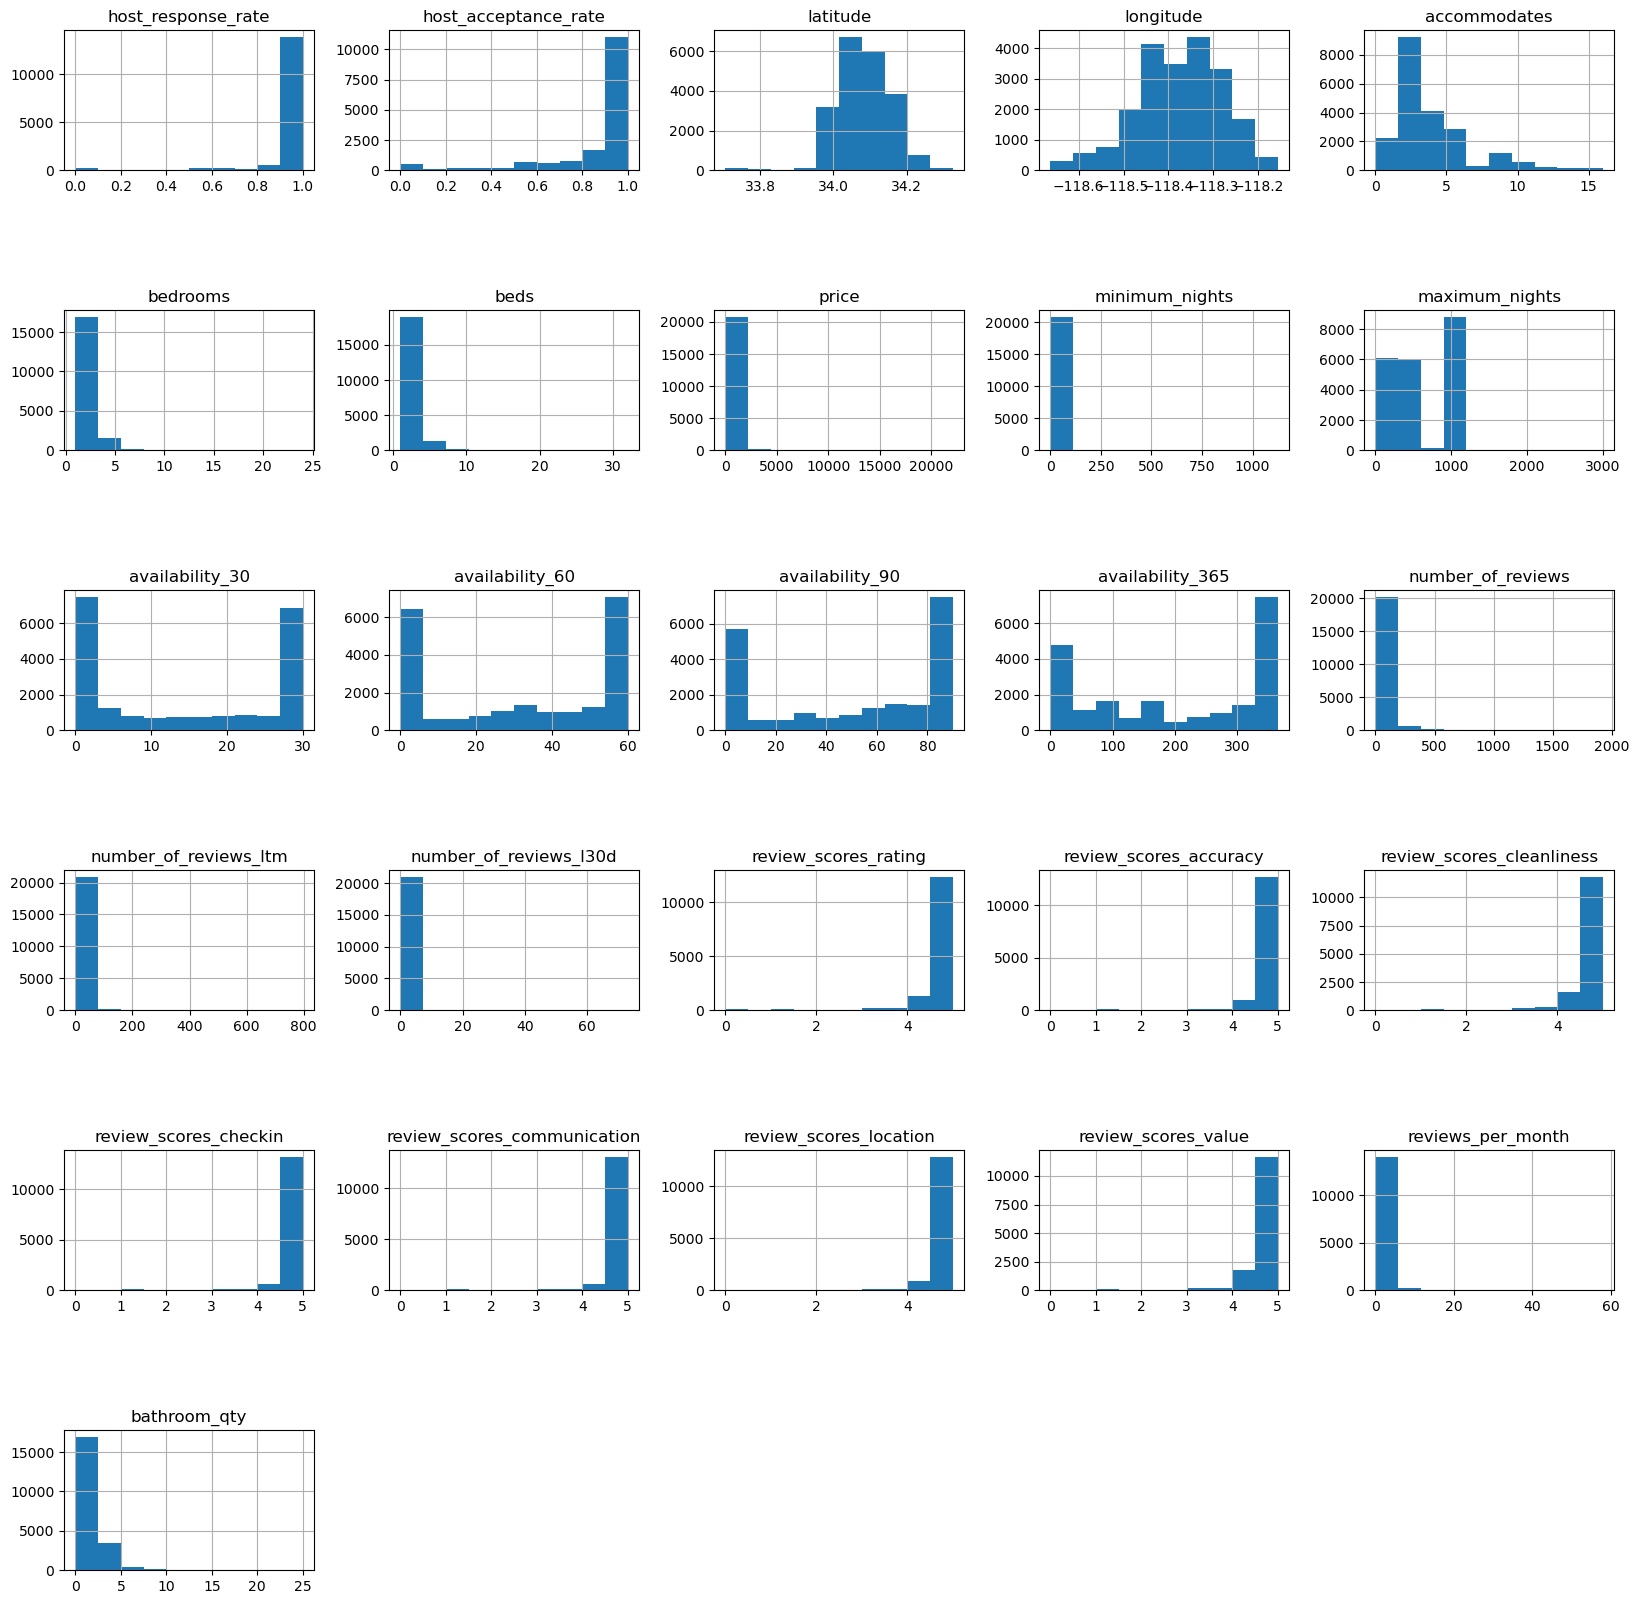

In [14]:
listings.hist(figsize=(20,20))
plt.subplots_adjust(hspace=1);

Observations:
1. Price has long tail and 0 values. high price could be true if the listing is a big house in an expensive neighbourhood. Zero price is not correct and need to be removed.
2. Bedrooms and beds have long tail but this could be true if the listing is an entire big house
3. minimum_nights also has long tail up to 1000 nights which is almost like 3 years. just keep it for now as it might not impact the price
4. number_of_reviews_l30d ( review last 30 days) had entry more than 30 which does not look righ. Will see if this have any impact to the price later on 

### Price
Let's create a histogram of the price column to get an overview of its distribution.

count    21003.000000
mean       264.465491
std        626.354250
min          0.000000
25%         86.000000
50%        133.000000
75%        231.000000
max      22092.000000
Name: price, dtype: float64


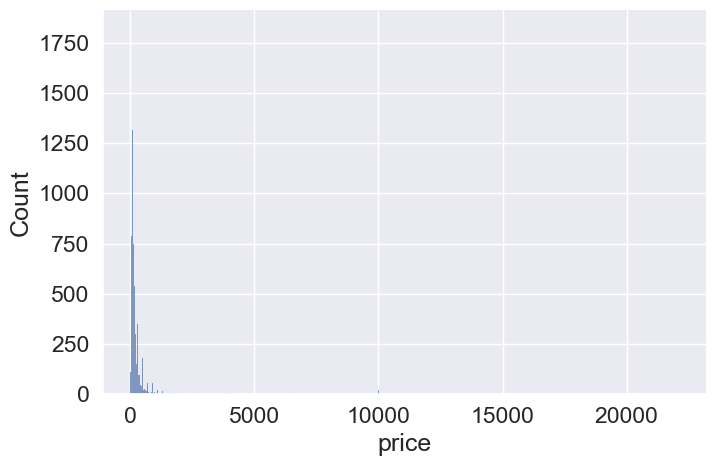

In [15]:

print(listings.price.describe())
sns.set_theme(font_scale=1.5, style="darkgrid")
sns.displot(data=listings, x="price", kind="hist", aspect=1.5)




The price is skewed with couple significantly high price. There are also listinsg with zero price. Let's print out the room_type and neighbourhoud of these listings.



In [16]:
# find the listing with price >10000. are they special listings?

listings[listings.price>10000][["price","room_type","accommodates","bathrooms_text","beds","neighbourhood_cleansed","room_type"]]


,price,room_type,accommodates,bathrooms_text,beds,neighbourhood_cleansed,room_type
7912,21053.0,Entire home/apt,16,12.5 baths,10.0,Bel-Air,Entire home/apt
13692,15000.0,Entire home/apt,16,13 baths,11.0,Bel-Air,Entire home/apt
27063,20084.0,Entire home/apt,16,20 baths,10.0,Bel-Air,Entire home/apt
27066,16078.0,Entire home/apt,14,9 baths,7.0,Hollywood Hills West,Entire home/apt
33638,22092.0,Entire home/apt,16,9.5 baths,11.0,Hollywood Hills West,Entire home/apt


In [17]:
# find the listings with price= 0

listings[listings.price==0][["price","room_type","accommodates","bathrooms_text","beds","neighbourhood_cleansed","room_type"]]


,price,room_type,accommodates,bathrooms_text,beds,neighbourhood_cleansed,room_type
16564,0.0,Hotel room,2,NaN,NaN,Hollywood,Hotel room
16566,0.0,Hotel room,4,NaN,NaN,Koreatown,Hotel room
17050,0.0,Hotel room,4,NaN,NaN,Venice,Hotel room
17343,0.0,Hotel room,5,NaN,NaN,Studio City,Hotel room
17349,0.0,Hotel room,8,NaN,NaN,Studio City,Hotel room
17601,0.0,Hotel room,0,NaN,NaN,Westwood,Hotel room
17818,0.0,Hotel room,0,NaN,NaN,Hollywood,Hotel room
17982,0.0,Hotel room,0,NaN,NaN,West Adams,Hotel room
17984,0.0,Hotel room,0,NaN,NaN,North Hollywood,Hotel room
21133,0.0,Hotel room,0,NaN,NaN,Beverly Grove,Hotel room



Observations:
1.	Listings > $10,000 are in Bel-Air and near Hollywood which  are the residential neighborhood of movie stars who live in Hollywood. The houses here are mansions in the foothill of Santa Monica Mountains. The real estate here is very expensive. The listing shows the room_type is entire home with more than 10 bed rooms and 10 bathrooms and accommodate more than 15 guests. These listings are the perfect for a big group to celebrate special occasion. To me, the price seems right for the area. will keep these listing for now.

2.	There are more than 10 listings with price equal to $0 which should be removed.




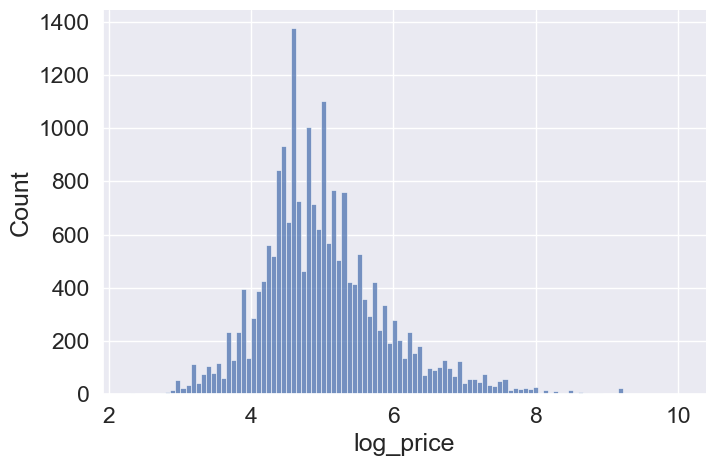

In [18]:

listings=listings[listings.price!=0]
listings.loc[:,"log_price"]=np.log(listings.loc[:,"price"])


#listings.loc[:,"log_price"]=np.log(listings.loc[:,"price"])
sns.displot(data=listings,x="log_price",kind="hist",aspect=1.5)

In [19]:
listings.shape

(20993, 38)

Price distrubion with log scale afer removing listings with zero price

# 5.0 Summary of wrangling

The original data shape was 21003x75. By the end of data wrangling, the data shape is 20993x38. 

1. 10 columns were removed due to listing price equal to zero


2. bathrooms and calendar_updated columns were removed due to no data 


3. 35 additional columns were removed due to un-useful data, for example hostname, website, picture ect. The main purpose is to keep the important features at a manageable size that may have good correlation to the price and location 


4. Remove special characters in host_response_rate, host_acceptance_rate, price columns and convert them from object to float


5. Split bathroom_text column into bathoom_qty and bathroom_type columns in hope to find the correlation between the bathroom_qty with price. There were couple listings that did not have the numeric bathroom count so they were replaced with correct numeric quantity


6. The target feature for predicting price are probably host rates, location, bedrooms, beds, bathrooms, and review ratings




